# Handling3dTraces : a numpy container of 3D traces


Handling3dTraces performs specific processing for 3D traces and plotting, available in module 
* `grand/basis/traces_event.py`

It is completely independent of the GRANDROOT format. Handling3dTraces can be initialize with GRANDROOT event file with function:
* `get_handling3dtraces(f_name, idx_evt=0)` in module `grand/dataio/root_file.py`

## Features

### Processing:

* Apply passband filter in place, causal or not
* Downsampling traces with scipy function
* Compute time for sample of each trace 
* Compute different kind of maximun value : max Hilbert transform, max norm, max abs with interpolation or not
* Compute an estimation of sigma noise and SNR 

### Trace/DU handling

* Copy an object Handling3dTraces
* Remove/Select trace with identifier or index
* Remove/Select trace with crieteria provided by user like : SNR, personnal norm , ...

### Plot/figure

* Traces like an image, interactive plot
* Footprint of max value, time of max
* Footprint 3D: time and max value of each trace
* Footprint of max value with a time slider
* Traces value
* Density power spectrum of traces


## Example : fake noisy pulse

Welcome to JupyROOT 6.26/02


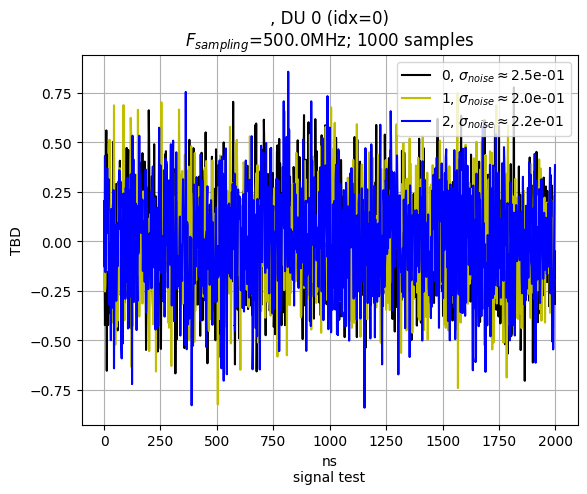

In [1]:
from grand.basis.traces_event import Handling3dTraces 
import numpy as np

np.random.seed(57)

a_noise = np.random.normal(0,0.25,5*3*1000).reshape((5,3,1000))
tr3d = Handling3dTraces("signal test")
tr3d.init_traces(a_noise, f_samp_mhz=500)
tr3d.plot_trace_idx(0)

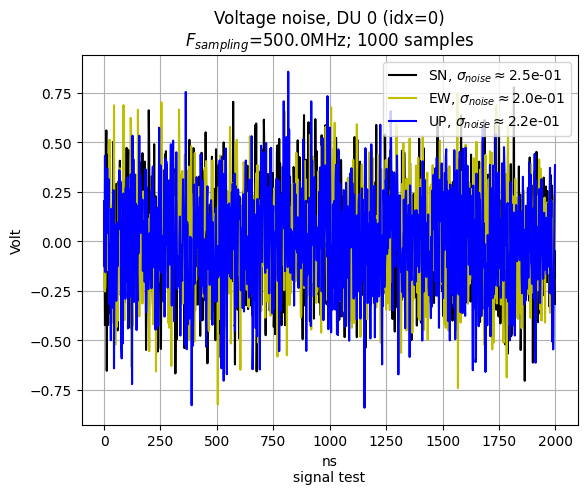

In [2]:
tr3d.set_unit_axis(str_unit="Volt", axis_name="dir", type_tr="Voltage noise")
tr3d.plot_trace_idx(0)

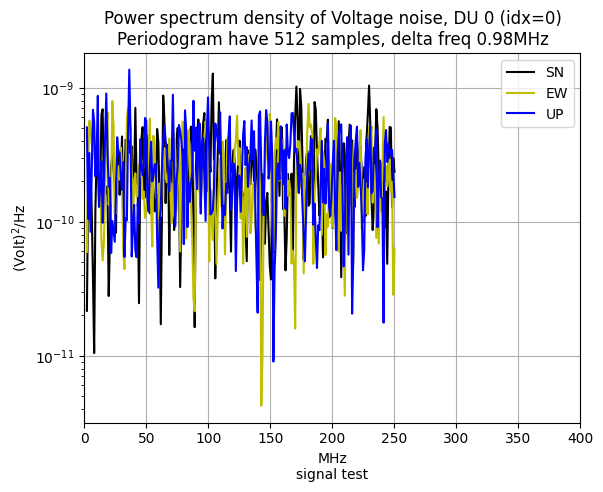

In [3]:
tr3d.plot_ps_trace_idx(0)

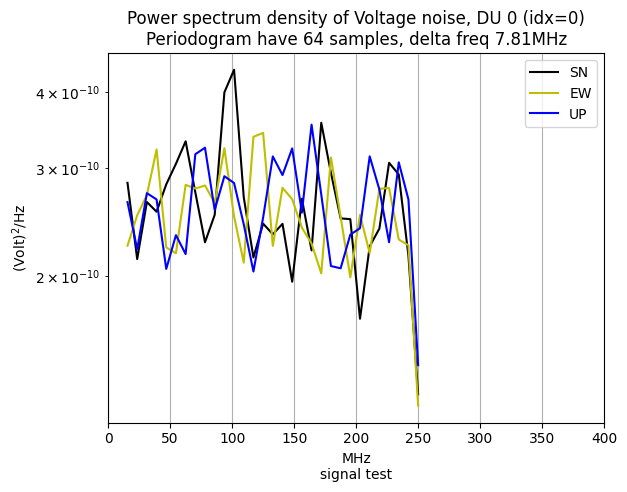

In [4]:
tr3d.set_periodogram(64)
tr3d.plot_ps_trace_idx(0)

In [5]:
x_max = 80
v_x, step = np.linspace(-x_max, x_max, 1000, retstep=True)


In [6]:
import scipy as scp
blackman = scp.signal.windows.blackman(1000)
v_y = np.sin(v_x) * blackman

In [7]:
tr3d.traces[:,0] += 4*v_y
tr3d.traces[:,1] += 3*v_y
tr3d.traces[:,2] += 0

The maximum value is $\sqrt{4^2+3^2+0^2}=5$

and the true time  of max is 

In [8]:
time_max = (x_max / step) * tr3d.get_delta_t_ns()[0]
print(f'True time max: {time_max} ns')

True time max: 999.0 ns


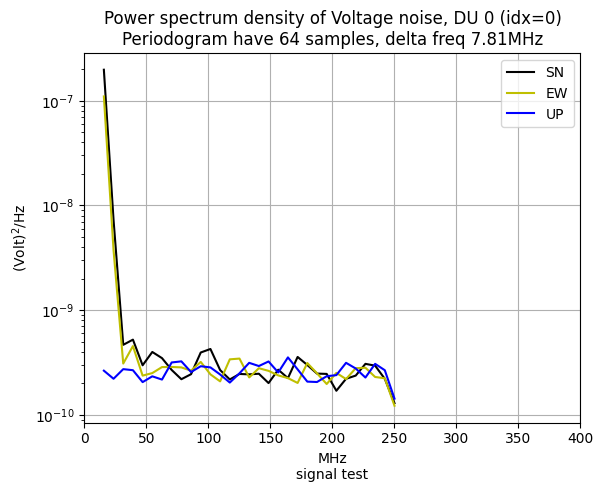

In [9]:
tr3d.plot_ps_trace_idx(0)

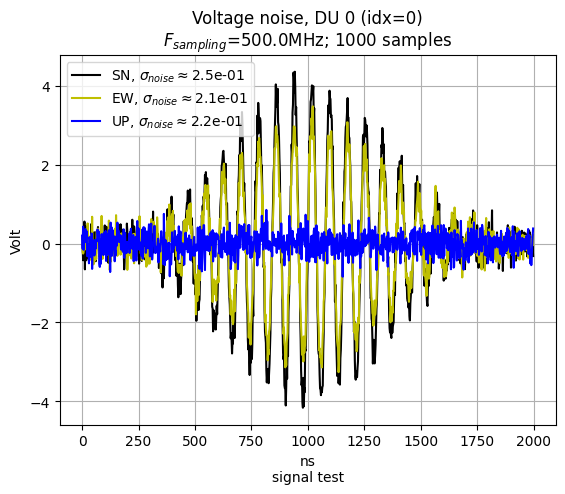

In [10]:
tr3d.plot_trace_idx(0)

### Find the maximum value

To add maximum value in plot call `get_tmax_vmax()`method

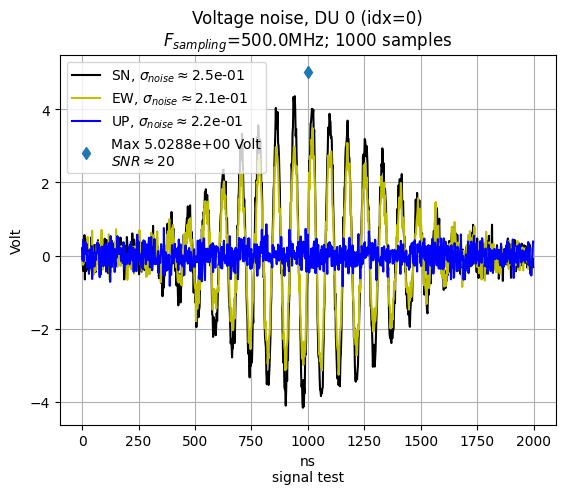

In [11]:
t_max, v_max = tr3d.get_tmax_vmax(hilbert=True, interpol="auto")
tr3d.plot_trace_idx(0)

In [12]:
print(f'time max estimated: {t_max[0]} ns')

time max estimated: 998.8690997898314 ns


Not to bad, now estimate maximum value wihtout Hilbert transform and interpolation

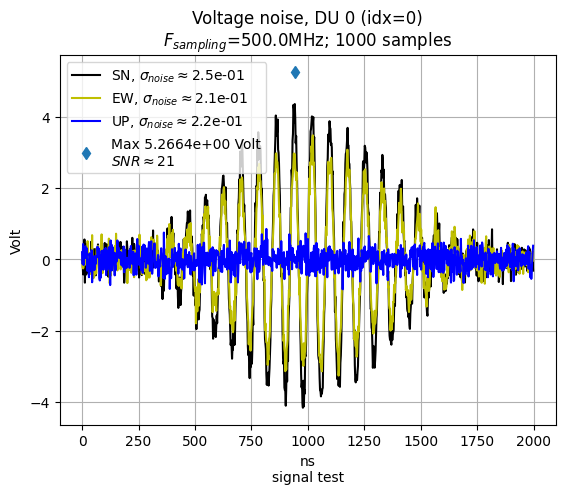

In [13]:
t_max, v_max = tr3d.get_tmax_vmax(hilbert=False, interpol="no")
tr3d.plot_trace_idx(0)

In [14]:
print(f'time max estimated: {t_max[0]} ns')

time max estimated: 942.0 ns


Estimation go to the "noisy" maximum

### Downsampling

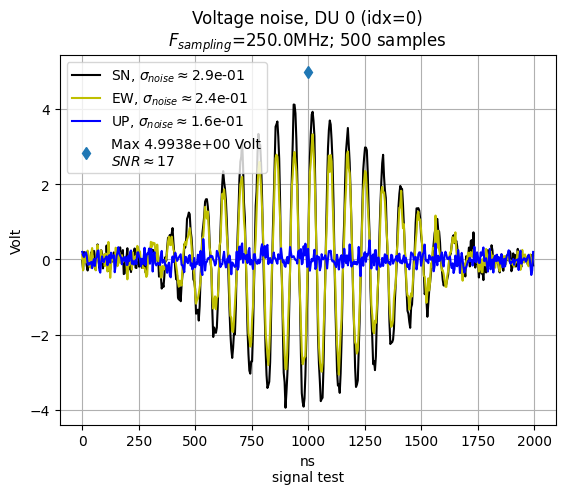

In [15]:
tr3d.downsize_sampling(2)
t_max, v_max = tr3d.get_tmax_vmax(hilbert=True, interpol="auto")
tr3d.plot_trace_idx(0)

In [16]:
print(f'time max estimated: {t_max[0]} ns')

time max estimated: 997.541747773586 ns


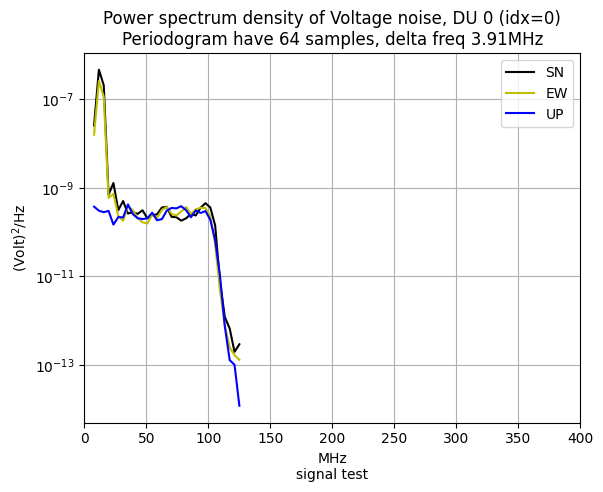

In [17]:
tr3d.plot_ps_trace_idx(0)

## With ROOT file

In [18]:
from grand.dataio.root_files import get_handling3dtraces

In [19]:
ef3d = get_handling3dtraces("../../sim2root/Common/sim_Xiaodushan_20221026_1200_1_SIBYLL23d_GP300_1618/tefield_1618-1618_L0_0000.root")

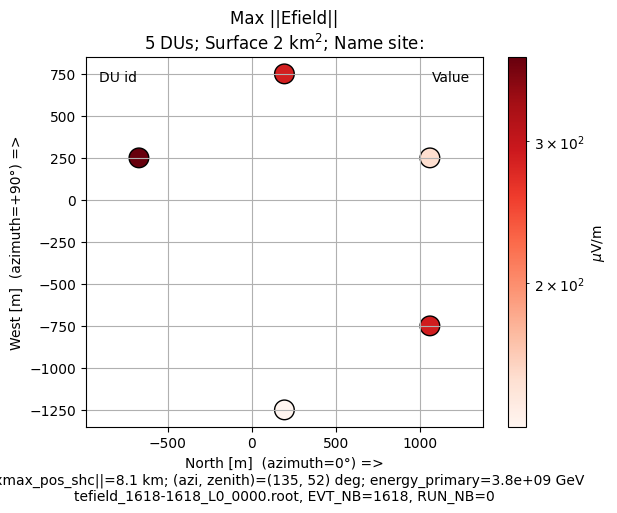

In [20]:
ef3d.plot_footprint_val_max()


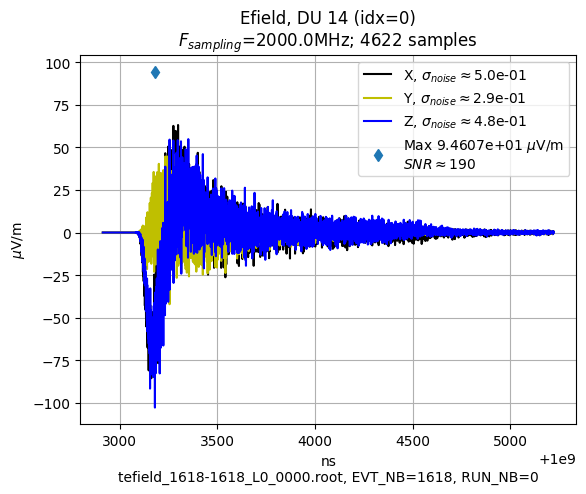

In [21]:
ef3d.get_tmax_vmax()
ef3d.plot_trace_idx(0)

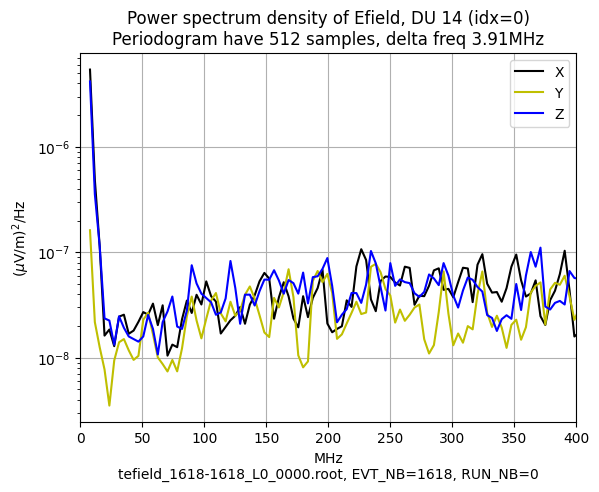

In [22]:
ef3d.plot_ps_trace_idx(0)

### Remove DU with low signal

In [23]:
ef3d.remove_trace_low_signal(200)

array([1, 2, 4])

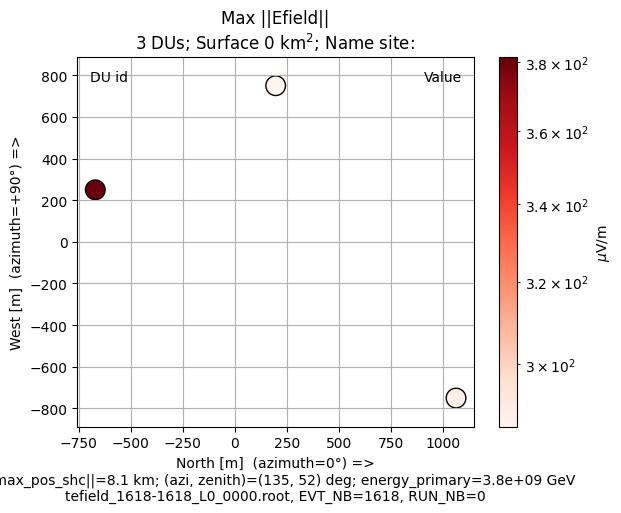

In [24]:
ef3d.plot_footprint_val_max()

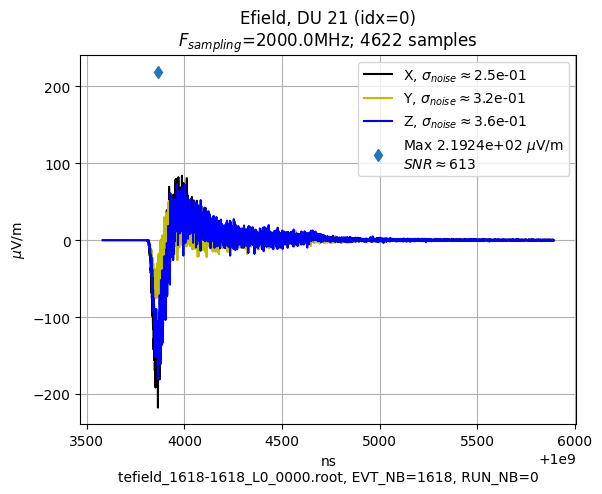

In [25]:
ef3d.get_tmax_vmax()
ef3d.plot_trace_idx(0)

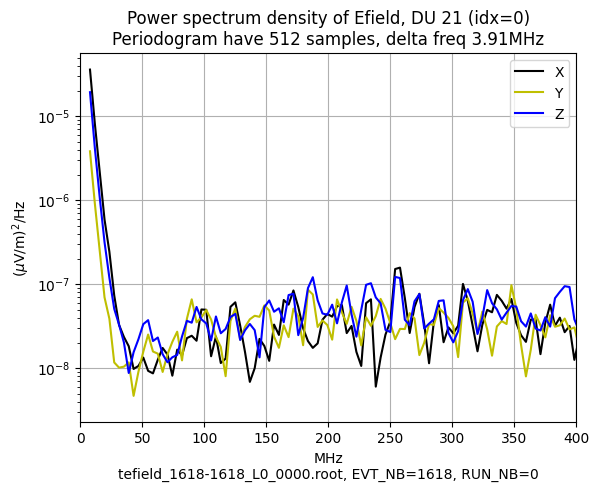

In [26]:
ef3d.plot_ps_trace_idx(0)

### Apply passband causal filter 

The frequency band is GRAND antenna ~ 80 MHz to 230 MHz

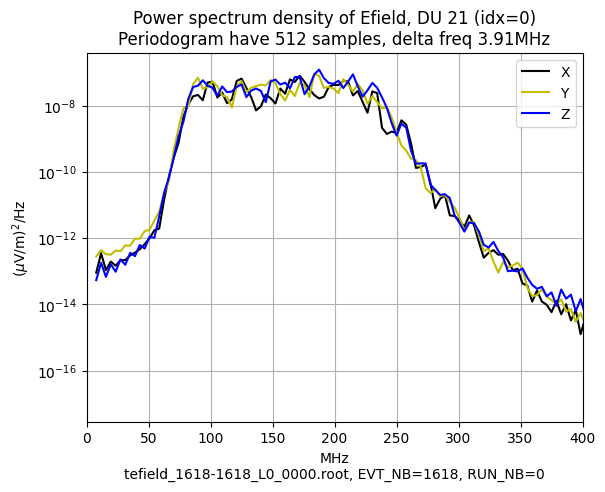

In [27]:
ef3d.apply_passband(80,230)
ef3d.plot_ps_trace_idx(0)

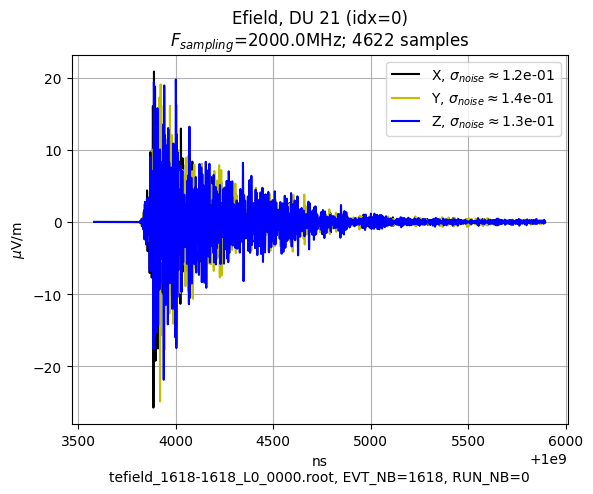

In [28]:
ef3d.plot_trace_idx(0)

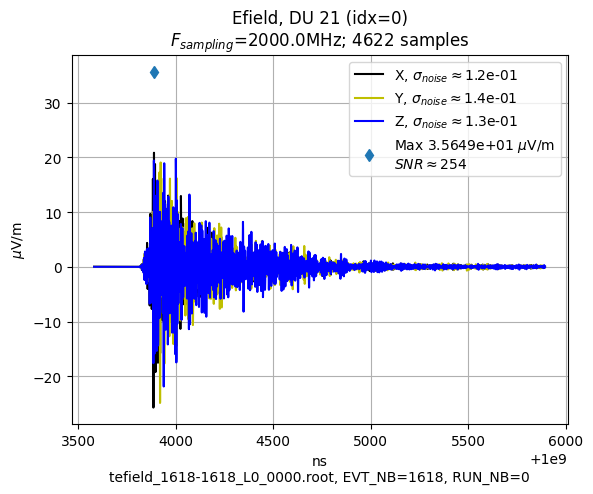

In [29]:
ef3d.get_tmax_vmax()
ef3d.plot_trace_idx(0)